# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

##### STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025aa05588

Name: Vivek Sharma

Email: 2025aa05588@wilp.bits-pilani.ac.in

Date: 

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
import random

In [18]:
# Deep learning frameworks (choose Keras or PyTorch)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image, ImageFile


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Environment setup complete.")
print("TensorFlow version:", tf.__version__)

Environment setup complete.
TensorFlow version: 2.20.0


### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [19]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats vs Dogs"
dataset_source = "Kaggle - Microsoft Cats vs Dogs Dataset"
n_samples =25000 
n_classes = 2
samples_per_class = "min:12500, max:12500, avg:12500"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

In [20]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """
Accuracy is chosen as the primary metric because the Cats vs Dogs dataset is a
balanced binary classification problem where both classes are equally important.
There is no significant cost difference between false positives and false negatives,
making accuracy an appropriate and reliable measure of overall model performance.
"""

In [21]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Kaggle - Microsoft Cats vs Dogs Dataset
Total Samples: 25000
Number of Classes: 2
Samples per Class: min:12500, max:12500, avg:12500
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
Accuracy is chosen as the primary metric because the Cats vs Dogs dataset is a
balanced binary classification problem where both classes are equally important.
There is no significant cost difference between false positives and false negatives,
making accuracy an appropriate and reliable measure of overall model performance.



### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

✅ Dataset cleaned. Removed 4 invalid/corrupted files.
Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.
Train/Test Split: 90/10
Training Samples: 22500
Testing Samples: 2498
Class Indices: {'Cat': 0, 'Dog': 1}


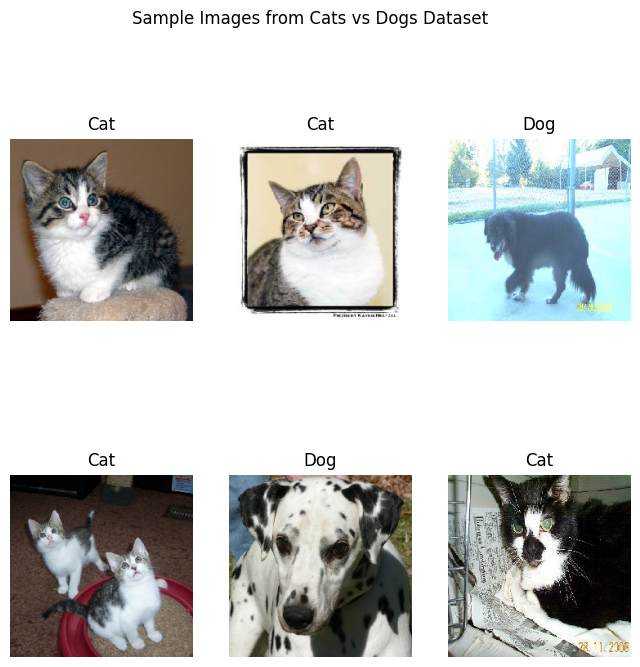

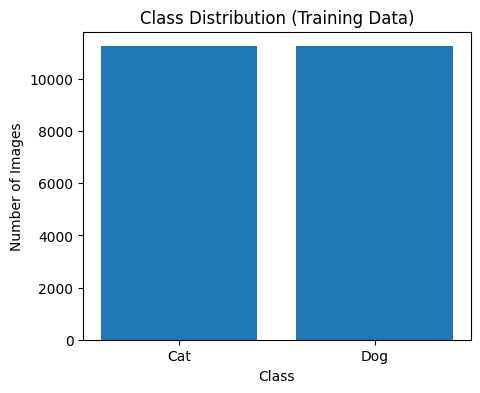

Image batch shape: (32, 224, 224, 3)
Pixel value range -> min: 0.0 , max: 1.0


In [22]:
# ================================
# PART 1.2: Data Exploration & Visualization
# PART 1.3: Data Preprocessing
# ================================
ImageFile.LOAD_TRUNCATED_IMAGES = False

shutil.rmtree("cats_dogs/.ipynb_checkpoints", ignore_errors=True)


# ----------------
# Dataset Path
# ----------------
# DATASET_DIR = "cats_dogs"   # <-- EXACT path as per your folder
def clean_dataset(dataset_dir):
    removed = 0
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            path = os.path.join(root, file)

            # allow only valid image extensions
            if not file.lower().endswith((".jpg", ".jpeg", ".png")):
                os.remove(path)
                removed += 1
                continue

            try:
                with Image.open(path) as img:
                    img.verify()
            except Exception:
                os.remove(path)
                removed += 1

    print(f"✅ Dataset cleaned. Removed {removed} invalid/corrupted files.")

clean_dataset(DATASET_DIR)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ----------------
# Train/Test Split
# ----------------
train_test_ratio = "90/10"

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42
)

# ----------------
# Required Metadata
# ----------------
train_samples = train_generator.samples
test_samples = test_generator.samples

print("Train/Test Split:", train_test_ratio)
print("Training Samples:", train_samples)
print("Testing Samples:", test_samples)
print("Class Indices:", train_generator.class_indices)


# ----------------
# Show Sample Images
# ----------------
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(8, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Sample Images from Cats vs Dogs Dataset")
plt.show()

# ----------------
# Class Distribution (Training Set)
# ----------------
counts = np.bincount(train_generator.classes)
labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(5, 4))
plt.bar(labels, counts)
plt.title("Class Distribution (Training Data)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# ----------------
# Image Statistics
# ----------------
print("Image batch shape:", images.shape)
print("Pixel value range -> min:", images.min(), ", max:", images.max())

In [9]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 22500
Test Samples: 2500


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [23]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    model = Sequential([
        # -------- Input Layer (Recommended) --------
        Input(shape=input_shape),

        # -------- Block 1 --------
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # -------- Block 2 --------
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # -------- Block 3 --------
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # -------- Global Average Pooling (MANDATORY) --------
        GlobalAveragePooling2D(),

        # -------- Output Layer --------
        Dense(n_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [24]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

In [25]:
# TODO: Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function
custom_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train Custom CNN

In [15]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [26]:
# TODO: Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
# For PyTorch: write training loop
EPOCHS = 10
history = custom_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    verbose=1
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 657s 930ms/step - accuracy: 0.6006 - loss: 0.6522 - val_accuracy: 0.6525 - val_loss: 0.6158
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 642s 913ms/step - accuracy: 0.6635 - loss: 0.6100 - val_accuracy: 0.7102 - val_loss: 0.5624
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 609s 864ms/step - accuracy: 0.7017 - loss: 0.5708 - val_accuracy: 0.7254 - val_loss: 0.5392
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.7184 - loss: 0.5577 - val_accuracy: 0.6954 - val_loss: 0.5724
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 645s 916ms/step - accuracy: 0.7345 - loss: 0.5375 - val_accuracy: 0.7502 - val_loss: 0.5234
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 660s 938ms/step - accuracy: 0.7384 - loss: 0.5296 - val_accuracy: 0.7522 - val_loss: 0.5086
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 662s 941ms/step - accuracy: 0.7561 - loss: 0.5131 - val_accuracy: 0.7650 - val_loss: 0.5148
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 640s 909ms/step - accuracy: 0.7603 - lo

In [27]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [28]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]
custom_cnn_final_loss = history.history['loss'][-1]

In [29]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 9199.35 seconds
Initial Loss: 0.6522
Final Loss: 0.4869


In [30]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics
custom_cnn_accuracy = 0.0  # TODO: accuracy_score(y_test, y_pred)
custom_cnn_precision = 0.0  # TODO: precision_score(y_test, y_pred, average='macro')
custom_cnn_recall = 0.0  # TODO: recall_score(y_test, y_pred, average='macro')
custom_cnn_f1 = 0.0  # TODO: f1_score(y_test, y_pred, average='macro')

In [ ]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")

In [ ]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "TODO: ResNet18/ResNet50/VGG16/VGG19"

In [ ]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    # TODO: Load pre-trained model without top layers
    # TODO: Freeze base layers
    # TODO: Add Global Average Pooling + custom classification head
    # TODO: Compile model
    pass

In [ ]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [ ]:
# REQUIRED: Count layers and parameters
frozen_layers = 0  # TODO: Count frozen layers
trainable_layers = 0  # TODO: Count trainable layers
total_parameters = 0  # TODO: Total parameters
trainable_parameters = 0  # TODO: Trainable parameters only

In [ ]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")

In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [ ]:
# Track training time
tl_start_time = time.time()

In [ ]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop

In [ ]:
tl_training_time = time.time() - tl_start_time

In [ ]:
# REQUIRED: Track initial and final loss
tl_initial_loss = 0.0  # TODO: Get from training history (first epoch)
tl_final_loss = 0.0  # TODO: Get from training history (last epoch)

In [ ]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# REQUIRED: Calculate all 4 metrics
tl_accuracy = 0.0  # TODO: accuracy_score(y_test, y_pred)
tl_precision = 0.0  # TODO: precision_score(y_test, y_pred, average='macro')
tl_recall = 0.0  # TODO: recall_score(y_test, y_pred, average='macro')
tl_f1 = 0.0  # TODO: f1_score(y_test, y_pred, average='macro')

In [ ]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 4.1 Metrics Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [ ]:
print(comparison_df.to_string(index=False))

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here